Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

1. Importing all the important libraries

In [130]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout

In [131]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

2. Data understanding

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [134]:
! ls /content/drive/MyDrive/chrisanne

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
 chrisanne_nn.ipynb
 chris_nn.ipynb
 CNN_assignment.zip
 House-Price_Keras.ipynb
'Skin cancer ISIC The International Skin Imaging Collaboration'


In [135]:
os.chdir('/content/drive/MyDrive/chrisanne')

In [136]:
!unzip CNN_assignment.zip


Archive:  CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [137]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [105]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [106]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2214
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [107]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [108]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed= seed,
  label_mode = 'int',
  class_names= None,
  color_mode= 'rgb',
  shuffle = True,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size,
  crop_to_aspect_ratio = False)

Found 6659 files belonging to 9 classes.
Using 5328 files for training.


In [112]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed= seed,
  label_mode = 'int',
  class_names= None,
  color_mode= 'rgb',
  shuffle = True,
  validation_split = 0.2,
  subset = 'validation',
  image_size = (img_height, img_width),
  batch_size = batch_size,
  crop_to_aspect_ratio = False)

Found 6659 files belonging to 9 classes.
Using 1331 files for validation.


In [113]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

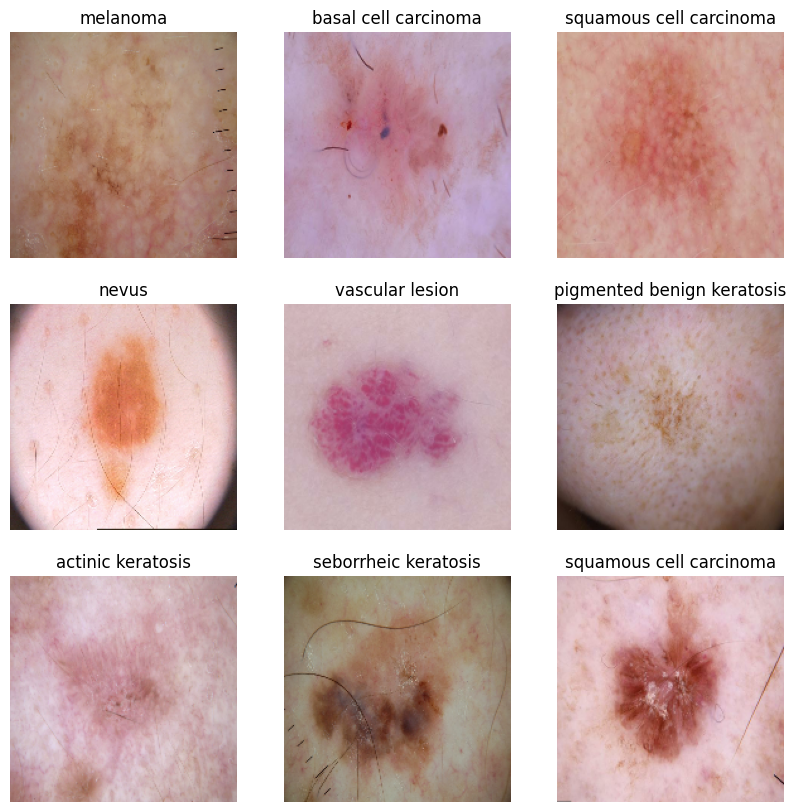

In [114]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [115]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

ReLU for the hidden layers and softmax for the output layer.


In [116]:
classes = 9
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

#1st Convolution Block : consists of 2 convolution layers & 1 Pooling layer
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd  Convolution Block : consists of 2 convolution layers & 1 Pooling layer
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening layer
model.add(Flatten())
model.add(Dense(512, activation ='relu'))

# Softmax Layer (Output)
model.add(Dense(classes, activation='softmax'))


In [117]:
### Your code goes here
## Number of classes is 9
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

optimizer used - adam

loss function - SparseCategoricalCrossentropy

In [118]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [119]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Train the model

In [120]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


167/167 [==============================] - 50s 143ms/step - loss: 1.9175 - accuracy: 0.2960 - val_loss: 1.5585 - val_accuracy: 0.3929
Epoch 2/20
167/167 [==============================] - 13s 79ms/step - loss: 1.4018 - accuracy: 0.4810 - val_loss: 1.3222 - val_accuracy: 0.4944
Epoch 3/20
167/167 [==============================] - 13s 79ms/step - loss: 1.1791 - accuracy: 0.5619 - val_loss: 1.1572 - val_accuracy: 0.5627
Epoch 4/20
167/167 [==============================] - 13s 78ms/step - loss: 0.9296 - accuracy: 0.6620 - val_loss: 1.1902 - val_accuracy: 0.6161
Epoch 5/20
167/167 [==============================] - 13s 78ms/step - loss: 0.7281 - accuracy: 0.7350 - val_loss: 0.9713 - val_accuracy: 0.6559
Epoch 6/20
167/167 [==============================] - 13s 79ms/step - loss: 0.5724 - accuracy: 0.7984 - val_loss: 0.9753 - val_accuracy: 0.7198
Epoch 7/20
167/167 [==============================] - 13s 79ms/step - loss: 0.4373 - accuracy: 0.8476 - val_loss: 1.0377 - val_accuracy: 0.7002
Ep

### Visualizing training results

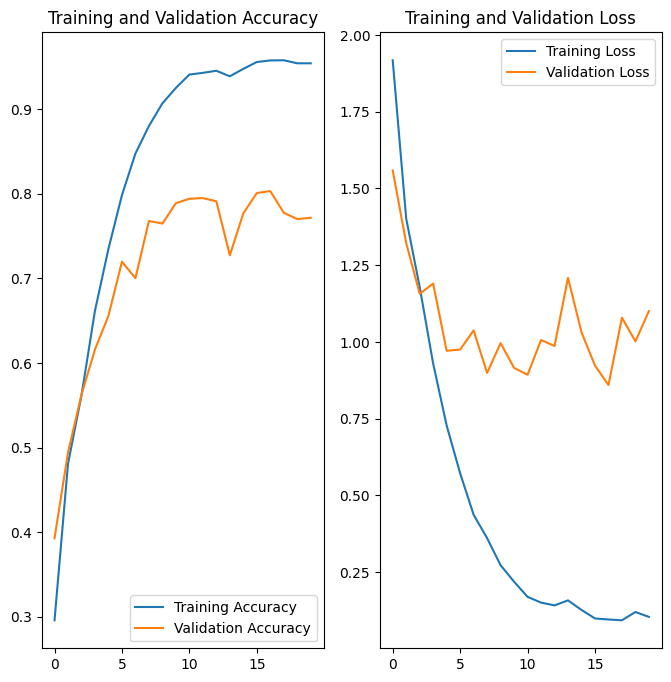

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

1.It is evident from our observation that the training accuracy significantly exceeds the validation accuracy. 2.One potential explanation for this could be the limited size of the training dataset,which would have led the model to overfit the training size in the data. To address this issue, we propose augmenting the dataset with authentic images to increase the size, and therby enhance the models generalization capabilities.

####Data Augmentation (to resolve overfitting/underfitting)

In [123]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

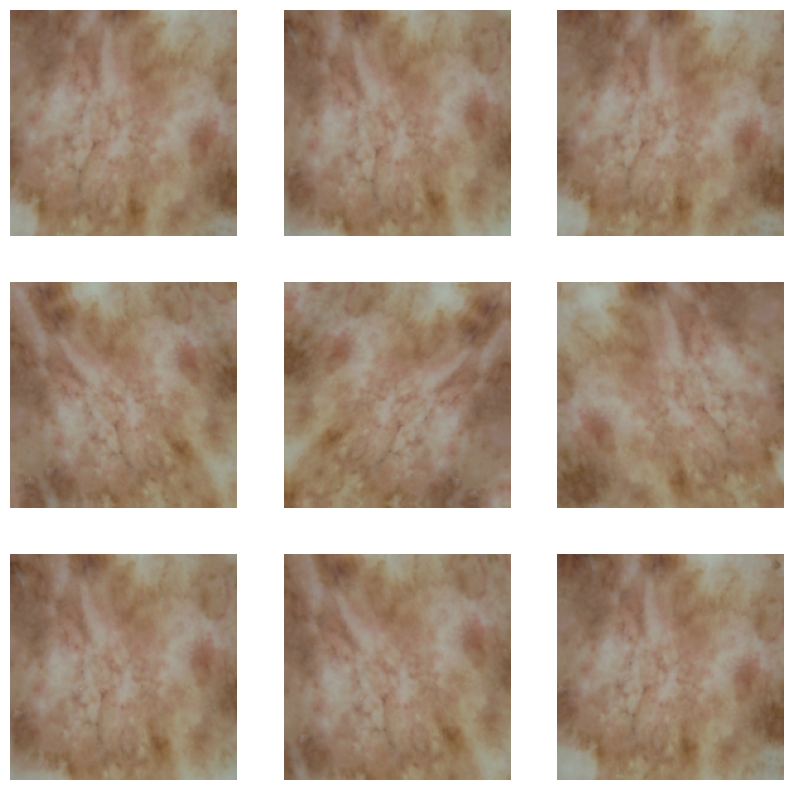

In [124]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):  
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### Todo: rebuild the model on augmented data

### Create the model, compile and train the model


In [125]:
##You can use Dropout layer if there is an evidence of overfitting in your findings

##our code goes here
#dropouts included here to deal with overfitting

model= Sequential()
model.add(data_augmentation)

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))


#1st Convolution Block : consists of 2 convolution layers & 1 Pooling layer
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))


# 2nd  Convolution Block : consists of 2 convolution layers & 1 Pooling layer
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))


# Flattening layer
model.add(Flatten())
model.add(Dense(512, activation ='relu'))
model.add(layers.Dropout(0.4))


# softmax layer
model.add(Dense(9, activation='softmax'))



### Compiling the model

In [126]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                      

### Training the model

In [127]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
167/167 [==============================] - 21s 108ms/step - loss: 2.4723 - accuracy: 0.1421 - val_loss: 2.1844 - val_accuracy: 0.1473
Epoch 2/20
167/167 [==============================] - 17s 104ms/step - loss: 2.1798 - accuracy: 0.1443 - val_loss: 2.1829 - val_accuracy: 0.1473
Epoch 3/20
167/167 [==============================] - 17s 105ms/step - loss: 2.1788 - accuracy: 0.1430 - val_loss: 2.1834 - val_accuracy: 0.1473
Epoch 4/20
167/167 [==============================] - 17s 105ms/step - loss: 2.1783 - accuracy: 0.1434 - val_loss: 2.1842 - val_accuracy: 0.1473
Epoch 5/20
167/167 [==============================] - 17s 105ms/step - loss: 2.1776 - accuracy: 0.1464 - val_loss: 2.1837 - val_accuracy: 0.1473
Epoch 6/20
167/167 [==============================] - 18s 105ms/step - loss: 2.1781 - accuracy: 0.1410 - val_loss: 2.1838 - val_accuracy: 0.1473
Epoch 7/20
167/167 [==============================] - 17s 105ms/step - loss: 2.1786 - accuracy: 0.1408 - val_loss: 2.1837 - val_ac

### Visualizing the results

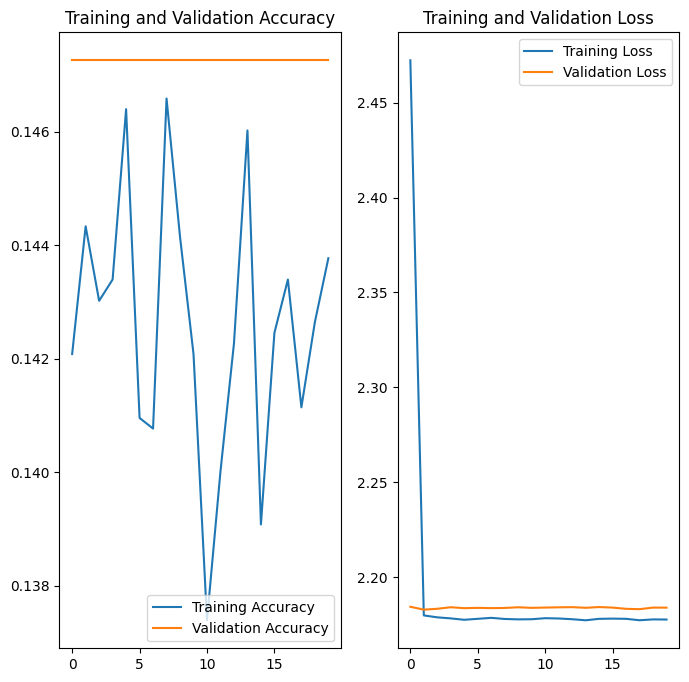

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The issue of overfitting has been addressed and resolved , as there is now comparable accuracy between the training and validation datasets. This was achieved through the implementation of data augmentation and dropout techniques.

However, the accuracy levels remain relatively low, indicating that the model is now sufferring from underfitting. there is still room for improvement in the models performance.

## Handling class imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

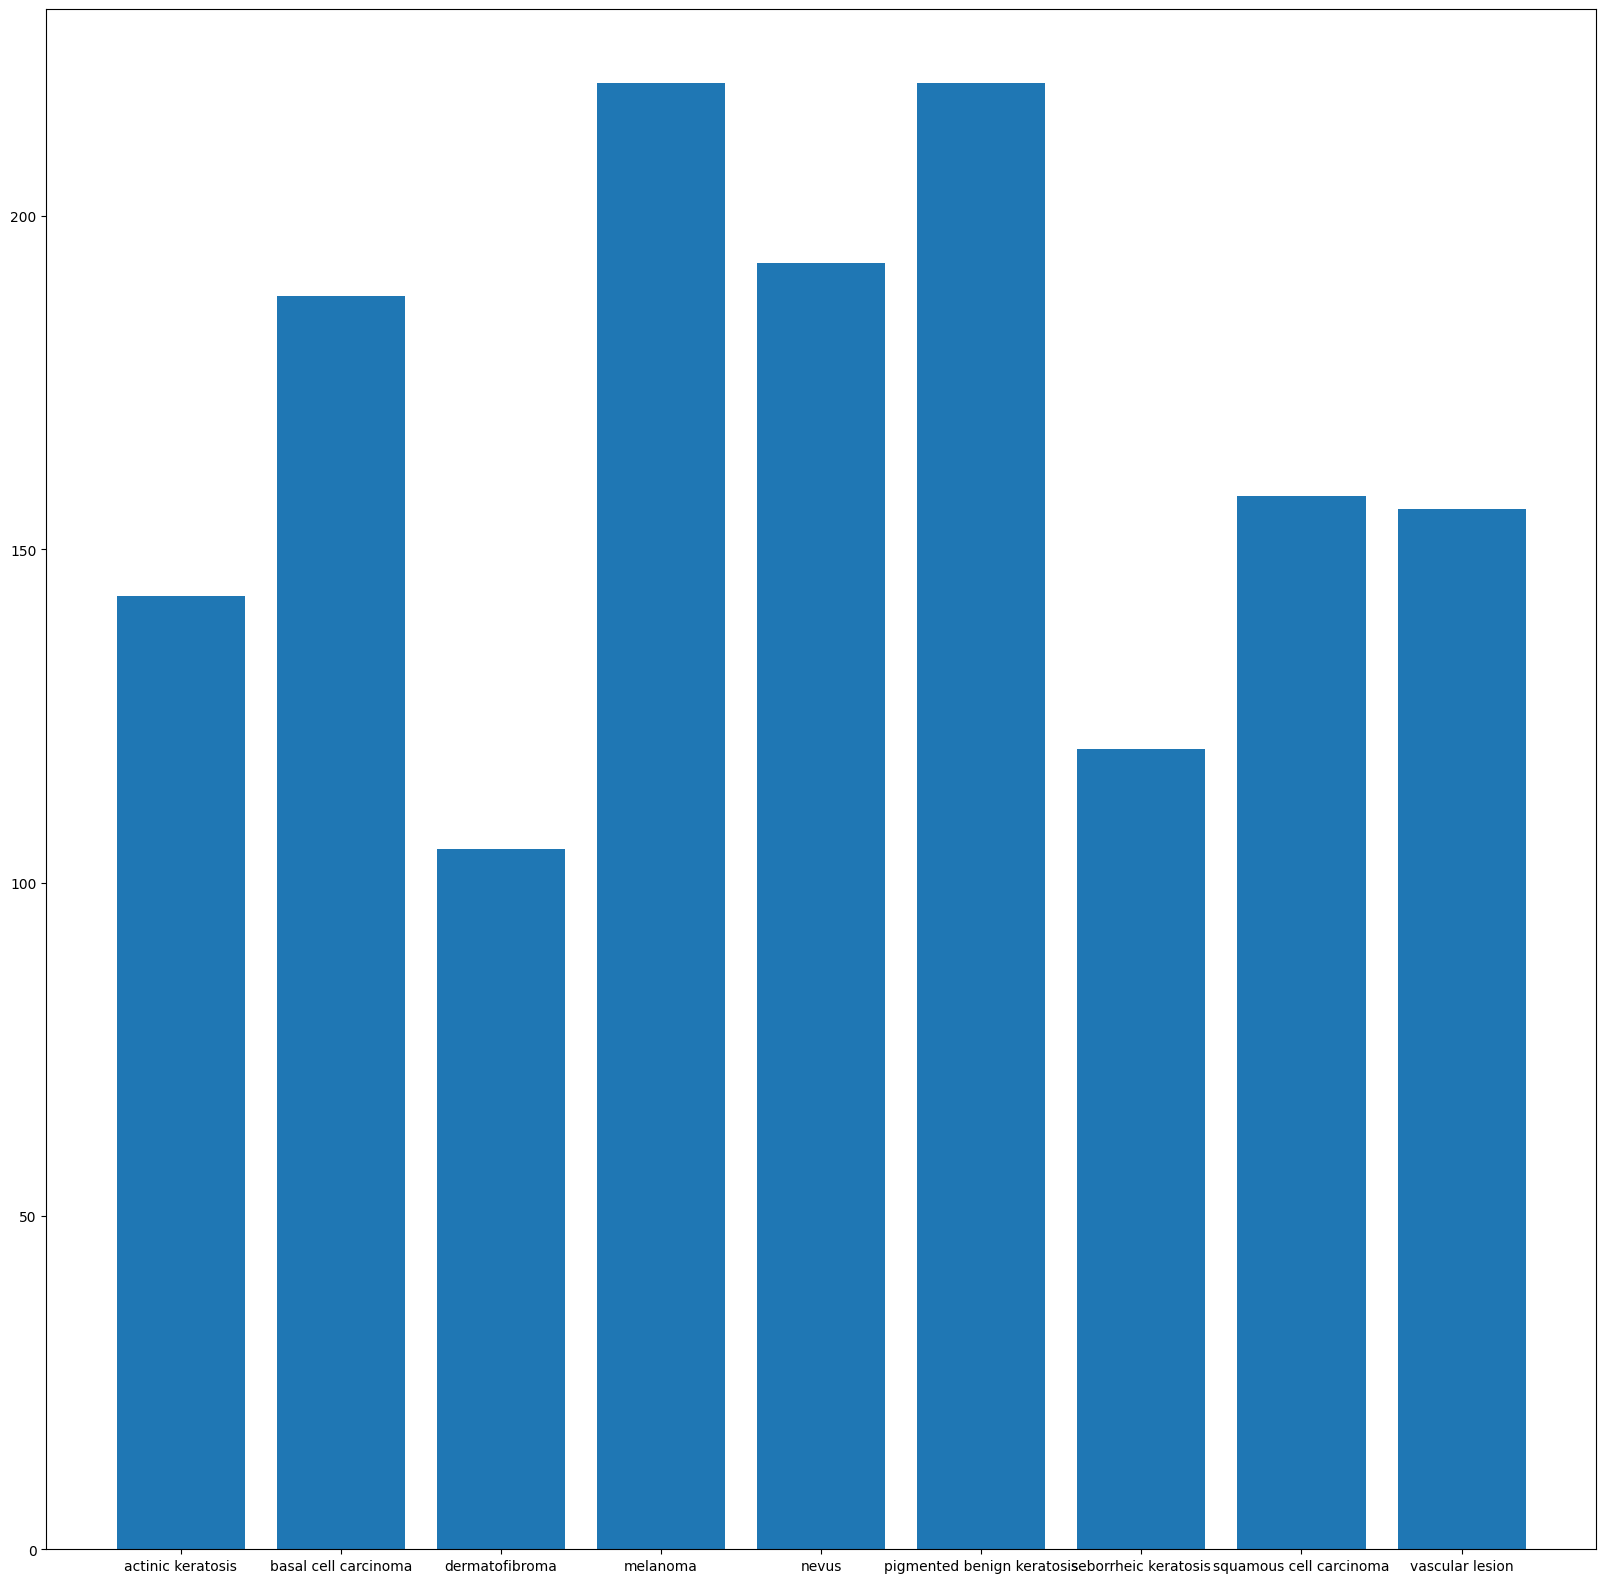

In [129]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [52]:
distribution = [0]*9
for _, labels_batch in train_ds :
  labels_arr = labels_batch.numpy()
  for label in labels_arr:
    distribution[label] = distribution[label] + 1
print(distribution)

[93, 297, 76, 340, 278, 372, 61, 142, 113]


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
  Seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data of count more than 100 in training


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [50]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [61]:
path_to_dir_train = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"

import Augmentor
for c in class_names :
  data_directory = os.path.join(path_to_dir_train, c)
  print(data_directory)

  p = Augmentor.Pipeline(data_directory)
  p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)

  # We add 500 samples per class to ensure that none of the classes are sparse


Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CB414BD60>: 100%|██████████| 500/500 [00:25<00:00, 19.82 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 364 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D91F5F580>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6CB4183880>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 425 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2304x1536 at 0x7F6D91EFAFE0>: 100%|██████████| 500/500 [01:45<00:00,  4.73 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F6CB4112B60>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CAC73A620>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6D177911E0>: 100%|██████████| 500/500 [00:47<00:00, 10.51 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CAC7384F0>: 100%|██████████| 500/500 [00:22<00:00, 22.55 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6D16C64580>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


###Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. 
Lets take a look at total count of augmented images.

In [62]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4445


We have **succesfully added 500 images to each class** in order to achive class balance

### Lets see the distribution of augmented data after adding new images to the original training data.

In [69]:
path_list_new = [g for g in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_60da1e34-8c13-4692-ae03-9a3cecc0c518.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_f7d8c0f2-1699-41c1-8e0c-fecfb17c636b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_6e4656aa-391c-4469-adb2-34827c3ba250.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_234a588c-2b13-4fb6-902c-d16c205f7193.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_ef155ae5-1f00-43b6-9245-5b694375b9c6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [70]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [71]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [75]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = orig_df.append(df2)

<ipython-input-75-6b1e44616a13>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = orig_df.append(df2)


In [78]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      923
basal cell carcinoma          855
nevus                         837
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
seborrheic keratosis          577
dermatofibroma                571
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [87]:
batch_size = 32
img_height = 180
img_width = 180
seed= 123

#### **Todo:** Create a training dataset

In [121]:
data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed= seed,
  label_mode = 'int',
  class_names= None,
  color_mode= 'rgb',
  shuffle = True,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size,
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio = False)

NotFoundError: ignored

#### **Todo:** Create a validation dataset

In [92]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed= seed,
  label_mode = 'int',
  class_names= None,
  color_mode= 'rgb',
  shuffle = True,
  validation_split = 0.2,
  subset = 'validation',
  image_size = (img_height, img_width),
  batch_size = batch_size,
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio = False)

NotFoundError: ignored

#### **Todo:** Create your model (make sure to include normalization)

In [93]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
                   
                    #1st Convolution Block : consists of 1 convolution layer & 1 Pooling layer
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),

                    # 2nd  Convolution Block : consists of 1 convolution layer & 1 Pooling layer
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),

                    # 3rd  Convolution Block : consists of 1 convolution layer & 1 Pooling layer
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),

                    layers.Flatten(),

                    # Softmax Layer (Output)
                    layers.Dense(128, activation='softmax'),
                    layers.Dense(classes)
])




#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [94]:
## your code goes here
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

#### **Todo:**  Train your model

In [95]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


KeyboardInterrupt: ignored

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
Finally our model is neither underfitting nor overfitting

Issues rectified : Class Imbalance (which led to underfitting) and Overfitting (caused by insufficient amount of training data)

Augmentor library helped us rectify the class imbalance and overfitiing issue. Our validation accuracy has increased by multiple folds.

Training accuracy now : 92%

Validation accuracy now : 81%

Training Loss : 0.20

Validation Loss : 0.81